# Run this Notebook

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/DeepRLCourse/Homework-3-Questions/blob/main/HW3_P3_MountainCarContinuous_REINFORCE.ipynb)  
[![Open in Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/DeepRLCourse/Homework-3-Questions/blob/main/HW3_P3_MountainCarContinuous_REINFORCE.ipynb)

# HW3: REINFORCE with continous action space in MountainCarContinous
> - Full Name: **Ali Ghasemzadeh**
> - Student ID: **401106339**


This notebook implements the **REINFORCE policy gradient algorithm** to train an agent in the **MountainCarContinuous-v0** environment. The objective is to evaluate the performance and stability of REINFORCE in a continuous action space.

Follow the instructions in each section to complete the homework.

**Grading Breakdown:**

- Practical Implementation: 80 points
- Conceptual Understanding: 20 points

# Setup

All required packages are pre-installed if using Google Colab.

Import the following libraries.

In [31]:
# Required Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal
import gym
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import base64
import imageio
import IPython
import logging
import warnings

# Disable warnings
logging.getLogger().setLevel(logging.ERROR)
warnings.filterwarnings('ignore', category=DeprecationWarning)

# DEVICE
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cpu')

Configure Matplotlib for Interactive and XKCD-Style Plots

In [32]:
# Set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
plt.ion()
plt.xkcd(scale=1, length=100, randomness=2)
matplotlib.rcParams['figure.figsize'] = (12, 6)

Record and Embed Simulation Videos in Jupyter Notebook

<b>embed_mp4:</b> Converts an MP4 video into a base64-encoded HTML tag for display in Jupyter Notebook.
<br>
<b>record_simulation:</b> Runs a policy in the environment, records the simulation, and saves it as an MP4 video.

In [33]:
def embed_mp4(filename):
    video = open(filename,'rb').read()
    b64 = base64.b64encode(video)
    tag = '''
    <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
    Your browser does not support the video tag.
    </video>'''.format(b64.decode())
    return IPython.display.HTML(tag)

def record_simulation(env, policy_net, filename, episodes=1, fps=30):
    filename = filename + ".mp4"
    with imageio.get_writer(filename, fps=fps) as video:
        for _ in range(episodes):
            state = env.reset()
            frame = env.render()  # Capture the first frame
            video.append_data(frame[0])

            done = False
            while not done:
                state_tensor = torch.FloatTensor(state).to(DEVICE)
                mean, _ = policy_net(state_tensor)
                action = mean.item()
                state, _, terminated, truncated, _ = env.step([action])

                frame = env.render()  # Capture the frame after taking the action
                video.append_data(frame[0])

                done = terminated or truncated
    return embed_mp4(filename)

# Explore the environment (10 points)

Initialize MountainCarContinuous Environment and Display State & Action Spaces

In [34]:
# Create the MountainCarContinuous environment
env = gym.make("MountainCarContinuous-v0")

# Print observation and action space
print("Observation Space:", env.observation_space)
print("Action Space:", env.action_space)

Observation Space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Action Space: Box(-1.0, 1.0, (1,), float32)


**Question 1: (5 points)**

How are the observation and action spaces defined in the MountainCarContinuous environment?

.....</br>
.....</br>


Define a Random Policy for Action Selection  

In [35]:
class RandomPolicy(object):

    def __init__(self, action_space_n):
        self.action_space_n = action_space_n

    def __call__(self, state):
        action_values, nan = torch.rand(self.action_space_n), np.nan
        return action_values, nan

Visualize the random policy.

In [36]:
random_policy = RandomPolicy(env.action_space.shape[0])

record_simulation(gym.make("MountainCarContinuous-v0", render_mode='rgb_array', new_step_api=True), random_policy, "Video_MountainCarContinuous_random_policy")

**Question 2: (5 points)**

How could an agent reach the goal in the MountainCarContinuous environment while using the least amount of energy? Explain a scenario describing the agent's behavior during an episode with most optimal policy.

.....</br>
.....</br>


# Agent with REINFORCE in a continuous action space in MountainCarContinuous-v0 (80 points)

### Policy Network Definition (10 points)

In continuous action spaces, instead of choosing from a discrete set of actions, the policy network learns a Gaussian distribution
$\pi_\theta(a|s)$ over possible actions. The agent then samples an action from this distribution:

$$a \sim \mathcal{N}(\mu_\theta(s), \sigma_\theta(s))$$

where:

- $\mu_\theta(s)$ is the mean of the action distribution.
- $\sigma_\theta(s)$ is the standard deviation (exploration factor).

The network is trained using policy gradients, reinforcing actions that lead to better rewards.


In [37]:
# Policy Network for Continuous Action Space
class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(PolicyNetwork, self).__init__()
        hidden_dim = 128
        self.layer1 = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU()
        )
        self.layer2 = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )

        self.mu = nn.Linear(hidden_dim, action_dim)
        self.log_std = nn.Parameter(torch.zeros(action_dim), requires_grad=True)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x) + x

        mu = self.mu(x)
        log_std = self.log_std
        std = torch.exp(log_std)
        return torch.distributions.Normal(mu, std)

### Computing Discounted Returns (15 points)

To implement a function that calculates the discounted return for each timestep in an episode.

$$[
G_t = \sum_{k=0}^{T-t} \gamma^k R_{t+k}
]$$

In [38]:
# REINFORCE Algorithm for Continuous Action Space
def compute_returns(rewards, gamma=0.99):
    returns = []
    R = 0
    for r in reversed(rewards):
        R = r + gamma * R
        returns.insert(0, R)
    return returns

### Implementing the REINFORCE Algorithm in continuous action space (45 points)

To train the agent using the standard policy gradient method.
The REINFORCE algorithm updates policy parameters by using the log-probability of actions multiplied by the discounted return.

This algorithm optimizes a **stochastic policy** $( \pi_{\theta}(a_t \mid s_t) )$ by updating its parameters in the direction that increases expected rewards. The update rule is based on the **policy gradient theorem**:  

$$[
\theta \leftarrow \theta + \alpha \sum_{t=0}^{T} \nabla_{\theta} \log \pi_{\theta}(a_t \mid s_t) G_t
]$$

where:  

- $( \theta )$ are the policy parameters (weights of the neural network).  
- $( \alpha )$ is the learning rate.  
- $( G_t )$ is the **discounted return** from timestep $( t )$:  

- $( \nabla_{\theta} \log \pi_{\theta}(a_t \mid s_t) )$ is the gradient of the log-probability of the selected action, used to adjust the policy in the correct direction.

In [39]:
from tqdm import tqdm

# TODO: Implement the REINFORCE algorithm without baseline
def reinforce(env, policy_net, optimizer, num_episodes=1000, gamma=0.99):
    episode_rewards = []
    progress_bar = tqdm(range(num_episodes), desc="Training", unit="episode")

    for episode in progress_bar:
        state = env.reset()
        log_probs, rewards = [], []
        done = False

        while not done:
            tensor_state = torch.tensor(state, dtype=torch.float32).to(DEVICE)
            dist = policy_net(tensor_state)
            action = dist.sample()
            log_prob = dist.log_prob(action)
            next_state, reward, done, info = env.step(action.cpu().detach().numpy())

            log_probs.append(log_prob)
            rewards.append(reward)
            state = next_state

        returns = compute_returns(rewards, gamma)
        returns = torch.tensor(returns, dtype=torch.float32)

        loss = 0
        for log_prob, G in zip(log_probs, returns):
            loss -= log_prob * G

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_reward = sum(rewards)
        total_return = returns.sum().item()

        episode_rewards.append(total_reward)

        progress_bar.set_postfix({
            "Reward": total_reward,
            "Return": total_return
        })

        if (episode + 1) % 50 == 0:
          print(f"Episode {episode + 1}, Reward: {sum(rewards)}")

    return episode_rewards

### Training (10 points)

To define key hyperparameters that influence training efficiency and convergence.

Hyperparameters like learning rate, discount factor, and number of episodes significantly impact the training process. Proper tuning is necessary to ensure stable learning while avoiding slow convergence or premature convergence to suboptimal policies.

In [40]:
# TODO: Define all necessary hyperparameters
INPUT_DIM =         env.observation_space.shape[0]     # TODO
OUTPUT_DIM =        env.action_space.shape[0]      # TODO
LEARNING_RATE =     0.005   # TODO
DISCOUNT_FACTOR =   0.99     # TODO
NUM_EPISODES =      1000      # TODO

# Initialize Policy
policy = PolicyNetwork(INPUT_DIM, OUTPUT_DIM).to(DEVICE)

# Optimizer
optimizer= optim.Adam(policy.parameters(), lr=LEARNING_RATE)

# Training
print("Training REINFORCE Algorithm for Continuous Action Space:")
rewards = reinforce(env, policy, optimizer, num_episodes=NUM_EPISODES, gamma=DISCOUNT_FACTOR)

Training REINFORCE Algorithm for Continuous Action Space:


Training:   5%|▌         | 50/1000 [00:45<13:44,  1.15episode/s, Reward=-85.2, Return=-7.56e+3]

Episode 50, Reward: -85.2426194964679


Training:  10%|█         | 100/1000 [01:30<13:17,  1.13episode/s, Reward=-75.9, Return=-6.91e+3]

Episode 100, Reward: -75.87879913087126


Training:  15%|█▌        | 150/1000 [02:16<13:03,  1.09episode/s, Reward=-71, Return=-6.41e+3]

Episode 150, Reward: -70.97871619340003


Training:  20%|██        | 200/1000 [03:00<11:21,  1.17episode/s, Reward=-73.4, Return=-6.61e+3]

Episode 200, Reward: -73.44499054502074


Training:  25%|██▌       | 250/1000 [03:43<11:26,  1.09episode/s, Reward=-48.5, Return=-4.34e+3]

Episode 250, Reward: -48.45669598288488


Training:  30%|███       | 300/1000 [04:26<09:17,  1.26episode/s, Reward=-4.46, Return=491]

Episode 300, Reward: -4.464254406577609


Training:  35%|███▌      | 350/1000 [05:08<09:39,  1.12episode/s, Reward=-64.2, Return=-5.73e+3]

Episode 350, Reward: -64.16387455307294


Training:  40%|████      | 400/1000 [05:49<07:35,  1.32episode/s, Reward=-15.2, Return=-280]

Episode 400, Reward: -15.158036918379537


Training:  45%|████▌     | 450/1000 [06:30<06:19,  1.45episode/s, Reward=55.6, Return=6.21e+3]

Episode 450, Reward: 55.61162280574468


Training:  50%|█████     | 500/1000 [07:00<04:19,  1.93episode/s, Reward=79.2, Return=8.13e+3]

Episode 500, Reward: 79.21351982890874


Training:  55%|█████▌    | 550/1000 [07:25<03:26,  2.18episode/s, Reward=55.9, Return=6.1e+3]

Episode 550, Reward: 55.919434089927876


Training:  60%|██████    | 600/1000 [07:48<03:01,  2.21episode/s, Reward=74.8, Return=7.53e+3]

Episode 600, Reward: 74.77603716411983


Training:  65%|██████▌   | 650/1000 [08:06<02:01,  2.87episode/s, Reward=81.7, Return=8.29e+3]

Episode 650, Reward: 81.69738279611391


Training:  70%|███████   | 700/1000 [08:22<01:17,  3.86episode/s, Reward=78.3, Return=7.86e+3]

Episode 700, Reward: 78.32253773403606


Training:  75%|███████▌  | 751/1000 [08:35<00:54,  4.56episode/s, Reward=67.6, Return=6.5e+3]

Episode 750, Reward: 66.054642340226


Training:  80%|████████  | 800/1000 [08:48<01:13,  2.71episode/s, Reward=71.3, Return=6.79e+3]

Episode 800, Reward: 71.33831308010365


Training:  85%|████████▌ | 850/1000 [09:01<00:49,  3.00episode/s, Reward=57.5, Return=5.76e+3]

Episode 850, Reward: 57.513891923634034


Training:  90%|█████████ | 900/1000 [09:13<00:30,  3.26episode/s, Reward=80.1, Return=7.93e+3]

Episode 900, Reward: 80.08703524722895


Training:  95%|█████████▌| 950/1000 [09:25<00:12,  3.93episode/s, Reward=88.4, Return=8.11e+3]

Episode 950, Reward: 83.07328844512017


Training: 100%|██████████| 1000/1000 [09:37<00:00,  1.73episode/s, Reward=78, Return=7.71e+3]

Episode 1000, Reward: 77.96657173189175


# Results (10 points)

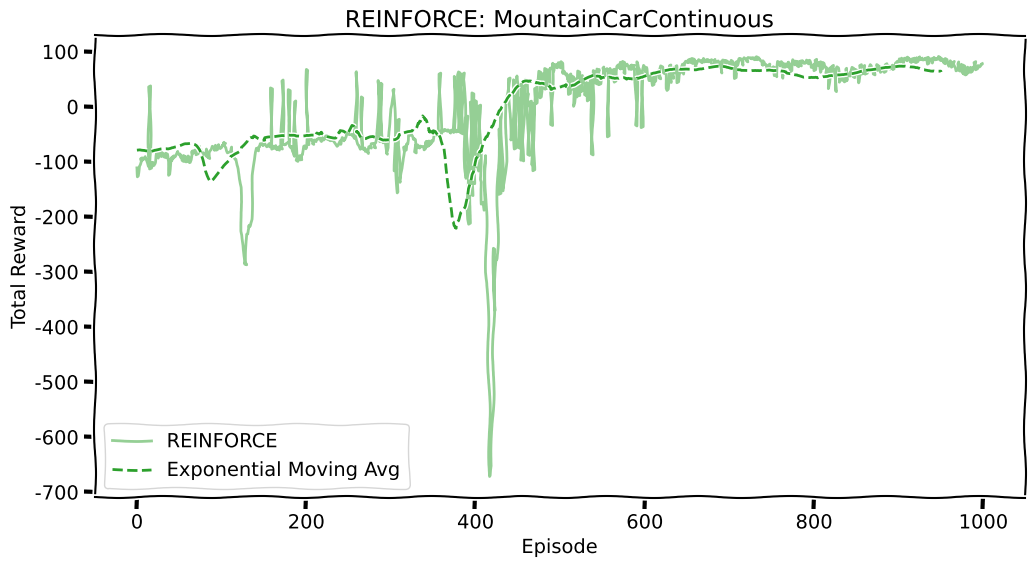

In [41]:
# Plotting Results
window_size = 50  # Moving average window size

# Exponential Moving Average calculation
def exponential_moving_average(data, window_size):
    alpha = 2 / (window_size + 1)  # Smoothing factor
    return np.convolve(data, [alpha * (1 - alpha) ** i for i in range(window_size)], mode='valid')

plt.plot(rewards, label="REINFORCE", alpha=0.5, color='tab:green')

# Plotting exponential moving averages
plt.plot(exponential_moving_average(rewards, window_size), label="Exponential Moving Avg", linestyle='--', color='tab:green')

plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.legend()
plt.title("REINFORCE: MountainCarContinuous")
plt.show()

In [42]:
mean_reward, std_reward = np.mean(rewards), np.std(rewards)
print(f"mean_reward = {mean_reward:.2f} +/- {std_reward:.4f}")

mean_reward = -2.74 +/- 96.0502


**Question 3: (10 points)**

What strategies can be employed to reduce catastrophic forgetting in continuous action space environments like MountainCarContinuous?
</br>(Hint: experience replay or target networks)

.....</br>
.....</br>


# Simulation

In [48]:
def embed_mp4(filename):
    video = open(filename,'rb').read()
    b64 = base64.b64encode(video)
    tag = '''
    <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
    Your browser does not support the video tag.
    </video>'''.format(b64.decode())
    return IPython.display.HTML(tag)

def record_simulation(env, policy_net, filename, episodes=1, fps=30):
    filename = filename + ".mp4"
    with imageio.get_writer(filename, fps=fps) as video:
        for _ in range(episodes):
            state = env.reset()
            frame = env.render()  # Capture the first frame
            video.append_data(frame[0])

            done = False
            while not done:
                state_tensor = torch.FloatTensor(state).to(DEVICE)
                x = policy_net.layer1(state_tensor)
                x = policy_net.layer2(x) + x
                mean = policy_net.mu(x)
                action = mean.item()
                state, _, terminated, truncated, _ = env.step([action])

                frame = env.render()  # Capture the frame after taking the action
                video.append_data(frame[0])

                done = terminated or truncated
    return embed_mp4(filename)

In [49]:
# Record the simulation using the optimal policy
record_simulation(gym.make("MountainCarContinuous-v0", render_mode='rgb_array', new_step_api=True), policy, "Video_MountainCarContinuous_REINFORCE")